In [1]:
from os import environ, path
import pandas as pd
import numpy as np

DATA_PATH = environ.get('DATA_PATH', '../data/')
%matplotlib inline

In [2]:
deliveries_data = pd.read_csv(
    path.join(DATA_PATH, 'historical_data.csv'), 
    parse_dates=['created_at', 'actual_delivery_time'])
deliveries_data['duration'] = (deliveries_data.actual_delivery_time - deliveries_data.created_at).dt.total_seconds()

In [3]:
deliveries_data.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'duration'],
      dtype='object')

## Clean data

In [4]:
date_outliers_threshold = pd.to_datetime('2014-12-31') 
duration_outliers_threshold = 60*60*6  # 6h
cleaned_data = deliveries_data[
    deliveries_data.created_at > date_outliers_threshold
][
    deliveries_data.duration < duration_outliers_threshold
].dropna(
    how='any', 
    subset=[
        'duration', 
        'market_id', 
        'store_primary_category',
        'total_onshift_dashers',
        'total_busy_dashers',
        'total_outstanding_orders'
    ],
)
print(deliveries_data.shape, '->', cleaned_data.shape)

(197428, 17) -> (176453, 17)


/home/michal/PycharmProjects/doordash/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


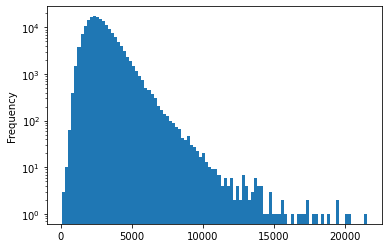

In [5]:
cleaned_data.duration.plot.hist(bins=100, log=True)

In [6]:
integer_columns = [
    'market_id',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
]
for column in integer_columns:
    cleaned_data[column] = cleaned_data[column].astype('int32')

## Features extraction

In [7]:
import sys
sys.path.append('/home/michal/PycharmProjects/doordash/doordash')
from app.features_extractors.calendar import extract_calendar_features
from app.features_extractors.categorical import extract_categorical_features, generate_encoders
from app.features_extractors.numerical import extract_numerical_features
from app.features_extractors.time import extract_time_features

### Basic

In [8]:
basic_features = extract_numerical_features(cleaned_data)
basic_features.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,4,3441,4,557,1239,33,14,21,446,861.0
1,1,1900,1,1400,1400,1,2,2,446,690.0
8,4,4771,3,820,1604,8,6,18,446,289.0
14,1,1525,1,1525,1525,5,6,8,446,795.0
15,2,3620,2,1425,2195,5,5,7,446,205.0


In [9]:
pd.DataFrame(cleaned_data.order_protocol).dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176225 entries, 0 to 197427
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   order_protocol  176225 non-null  float64
dtypes: float64(1)
memory usage: 2.7 MB


### Categories

In [10]:
encoders = generate_encoders(cleaned_data)

In [11]:
categorical_features = extract_categorical_features(cleaned_data, encoders)
categorical_features.head()

,store_primary_category_afghan,store_primary_category_african,store_primary_category_alcohol,store_primary_category_alcohol-plus-food,store_primary_category_american,store_primary_category_argentine,store_primary_category_asian,store_primary_category_barbecue,store_primary_category_belgian,store_primary_category_brazilian,...,market_id_4,market_id_5,market_id_6,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calendar

In [12]:
calendar_features = extract_calendar_features(cleaned_data)
calendar_features.head()

,day_cos,day_sin,month_cos,month_sin,quarter_cos,quarter_sin,season_cos,season_sin,year,dayofyear_cos,dayofyear_sin,dayofweek_cos,dayofweek_sin,is_weekend,days_until_holidays,days_after_holidays,is_holiday
0,0.222521,0.974928,0.5,0.866025,6.123234e-17,1.0,1.0,0.0,2015,-0.991677,-0.128748,-0.900969,-0.433884,False,10,18,False
16,0.222521,0.974928,0.5,0.866025,6.123234e-17,1.0,1.0,0.0,2015,-0.991677,-0.128748,-0.900969,-0.433884,False,10,18,False
51,0.222521,0.974928,0.5,0.866025,6.123234e-17,1.0,1.0,0.0,2015,-0.991677,-0.128748,-0.900969,-0.433884,False,10,18,False
72,0.222521,0.974928,0.5,0.866025,6.123234e-17,1.0,1.0,0.0,2015,-0.991677,-0.128748,-0.900969,-0.433884,False,10,18,False
121,0.222521,0.974928,0.5,0.866025,6.123234e-17,1.0,1.0,0.0,2015,-0.991677,-0.128748,-0.900969,-0.433884,False,10,18,False


### Time

In [13]:
time_features = extract_time_features(cleaned_data)
time_features.head()

,minute_of_day_cos,minute_of_day_sin
0,0.913545,-0.406737
1,0.841039,-0.540974
8,0.998848,0.047978
14,0.587785,0.809017
15,0.838671,0.544639


### Features summary

In [14]:
features = pd.concat([
    basic_features,
    categorical_features,
    calendar_features,
    time_features,
], axis=1)

## Target

In [15]:
target = cleaned_data.reindex(columns=['duration'])
# target = pd.DataFrame(
#     MinMaxScaler().fit_transform(target), 
#     columns=['minmax_scaled_duration'], 
#     index=cleaned_data.index)

## Save prepared data

In [16]:
dataset = pd.concat([
    features,
    target
], axis=1)
dataset

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,dayofyear_sin,dayofweek_cos,dayofweek_sin,is_weekend,days_until_holidays,days_after_holidays,is_holiday,minute_of_day_cos,minute_of_day_sin,duration
0,4,3441,4,557,1239,33,14,21,446,861.0,...,-0.128748,-0.900969,-0.433884,False,10,18,False,0.913545,-0.406737,3779.0
1,1,1900,1,1400,1400,1,2,2,446,690.0,...,-0.128748,0.623490,0.781831,False,6,22,False,0.841039,-0.540974,4024.0
8,4,4771,3,820,1604,8,6,18,446,289.0,...,-0.128748,1.000000,0.000000,False,0,0,True,0.998848,0.047978,1586.0
14,1,1525,1,1525,1525,5,6,8,446,795.0,...,-0.128748,-0.900969,0.433884,False,4,24,False,0.587785,0.809017,2273.0
15,2,3620,2,1425,2195,5,5,7,446,205.0,...,-0.128748,0.623490,0.781831,False,20,8,False,0.838671,0.544639,2988.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,3,1389,3,345,649,17,17,23,251,331.0,...,-0.128748,0.623490,0.781831,False,97,1,False,0.996566,0.082808,3907.0
197424,6,3010,4,405,825,12,11,14,251,915.0,...,-0.128748,-0.900969,-0.433884,False,3,25,False,0.999990,0.004363,3383.0
197425,5,1836,3,300,399,39,41,40,251,795.0,...,-0.128748,-0.222521,-0.974928,True,23,5,False,0.317305,0.948324,3008.0
197426,1,1175,1,535,535,7,7,12,446,384.0,...,-0.128748,0.623490,-0.781831,True,15,13,False,0.078459,-0.996917,3907.0


In [17]:
dataset.to_csv(path.join(DATA_PATH, 'cleaned_data.csv'))

In [18]:
import pickle

In [19]:
encoders_file_path = path.join(DATA_PATH, 'cleaned_data_encoders.pickle')
pickle.dump(encoders, open(encoders_file_path, "wb"))